In [1]:
%load_ext autoreload
%autoreload 1
import pandas as pd
import os
import sys
scriptpath = "binarygridsearch.py"
# Do the import
sys.path.append(os.path.abspath(scriptpath))
# Do the import
import binarygridsearch as bgs
%aimport binarygridsearch

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.tree import _tree


In [2]:
#From here: https://aysent.github.io/2015/11/08/random-forest-leaf-visualization.html
def leaf_depths(tree, node_id = 0):
    
    '''
    tree.children_left and tree.children_right store ids
    of left and right chidren of a given node
    '''
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    '''
    If a given node is terminal, 
    both left and right children are set to _tree.TREE_LEAF
    '''
    if left_child == _tree.TREE_LEAF:
        
        '''
        Set depth of terminal nodes to 0
        '''
        depths = np.array([0])
    else:
        '''
        Get depths of left and right children and
        increment them by 1
        '''
        left_depths = leaf_depths(tree, left_child) + 1
        right_depths = leaf_depths(tree, right_child) + 1
 
        depths = np.append(left_depths, right_depths)
 
    return depths

In [9]:
def getForestDepths(X, y, kwargs):
    clf = RandomForestClassifier(**kwargs)
    clf.fit(X, y)
    allDepths = [leaf_depths(estimator.tree_) 
                 for estimator in clf.estimators_]
    return {"min": np.hstack(allDepths).min(),
           "max": np.hstack(allDepths).max()}

In [10]:
data = load_breast_cancer()
X, y = data.data, data.target

rfArgs = {"random_state": 0,
          "n_jobs": -1,
          "class_weight": "balanced",
         "n_estimators": 18,
         "oob_score": True}

In [11]:
getForestDepths(X, y, rfArgs)

{'min': 2, 'max': 9}

In [13]:
def getForestAccuracy(X, y, metric, kwargs):
    clf = RandomForestClassifier(**kwargs)
    clf.fit(X, y)
    y_pred = clf.oob_decision_function_[:, 1]
    return metric(y, y_pred)

,max_depth,score,time,scoreTimeRatio
0,2,0.980531,1.037448,0.009858
1,9,0.750646,0.154658,0.138930
2,6,1.158169,0.037448,1.000000
3,4,0.158169,0.244608,0.000000


,max_depth,score,time
0,2,0.982189,0.155940
1,9,0.980736,0.132366
2,6,0.983312,0.129236
3,4,0.976990,0.134768


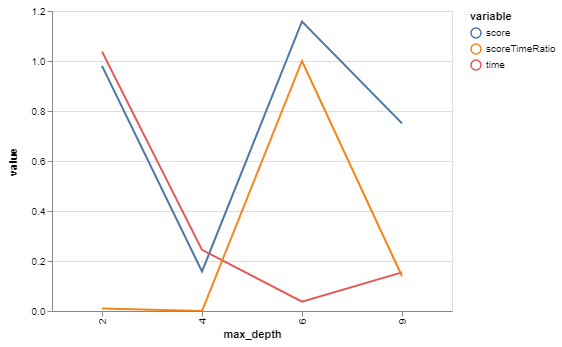

In [14]:
max_depth = bgs.compareValsBaseCase(X, 
                    y, 
                    getForestAccuracy,        
                    rfArgs, 
                    roc_auc_score, 
                    "max_depth", 
                    0, 
                    2, 
                    9)
bgs.showTimeScoreChartAndGraph(max_depth)